## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [6]:
img_path = 'E:/mmpose/data/test/multi-person.jpeg'

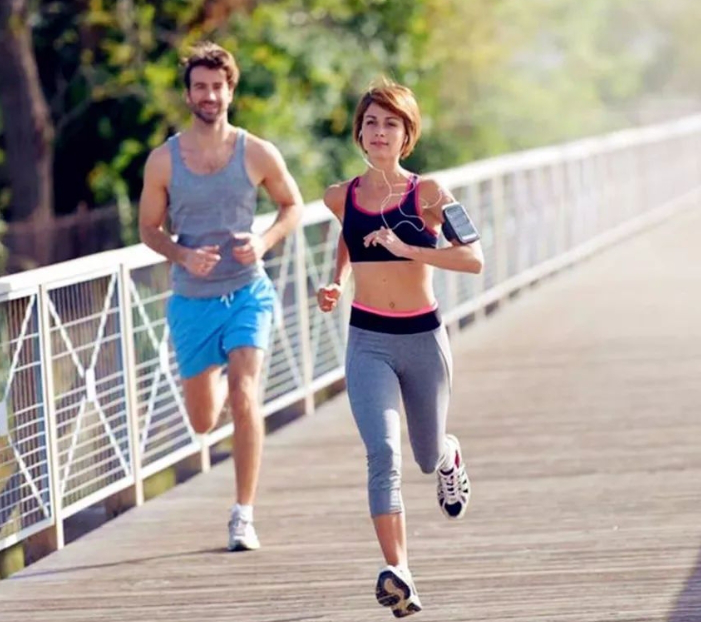

In [7]:
Image.open(img_path)

## 构建目标检测模型（任选一个运行）

In [8]:
# Faster R CNN
detector = init_detector(
    'E:/mmpose/mmpose/demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py',
    'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth',
    device=device
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [9]:
# # RTMPose-Tiny
# # https://github.com/open-mmlab/mmpose/tree/dev-1.x/projects/rtmpose
# detector = init_detector(
#     'projects/rtmpose/rtmdet/person/rtmdet_m_640-8xb32_coco-person.py',
#     'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth',
#     device=device
# )

## 构建人体姿态估计模型

In [10]:
pose_estimator = init_pose_estimator(
    'E:/mmpose/mmpose/configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


## 预测-目标检测

In [11]:
# 对detector的anchor box大小进行一些配置
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

10/09 20:09:39 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [12]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

In [13]:
detect_result.keys()

['pred_instances', 'ignored_instances', 'gt_instances']

In [15]:
# 预测类别
# 我感觉0是人，67、24应该不属于人吧
detect_result.pred_instances.labels

tensor([ 0,  0, 67, 24, 67], device='cuda:0')

In [16]:
# 置信度
detect_result.pred_instances.scores

tensor([0.9992, 0.9991, 0.7869, 0.0888, 0.0797], device='cuda:0')

In [14]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
detect_result.pred_instances.bboxes

tensor([[309.2784,  86.4893, 482.6124, 617.8478],
        [135.4031,  41.9392, 300.6700, 549.9795],
        [440.9910, 203.5416, 479.0688, 245.9288],
        [165.3925, 127.8550, 261.8602, 218.9799],
        [197.9870, 230.3026, 244.1183, 250.0321]], device='cuda:0')

## 置信度阈值过滤，获得最终目标检测预测结果

In [16]:
# 置信度阈值
CONF_THRES = 0.5

In [17]:
# 过滤类别是人的框、过滤置信度>0.5的框
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

In [18]:
bboxes

array([[309.27838 ,  86.48928 , 482.61237 , 617.8478  ],
       [135.40314 ,  41.939228, 300.67004 , 549.9795  ]], dtype=float32)

## 预测-关键点

In [19]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

10/09 20:15:30 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


In [20]:
len(pose_results)

2

In [21]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [22]:
data_samples.keys()

['pred_instances', 'gt_instances', '_pred_heatmaps', 'pred_fields']

## 预测结果-关键点坐标

In [23]:
# 每个人，17个关键点，坐标
data_samples.pred_instances.keypoints.shape

(2, 17, 2)

In [24]:
# 索引为 0 的人，每个关键点的坐标
data_samples.pred_instances.keypoints[0,:,:]

array([[382.972754  , 131.633986  ],
       [393.35084963, 121.25589037],
       [372.59465837, 121.25589037],
       [408.91799307, 136.82303381],
       [357.02751493, 131.633986  ],
       [429.67418432, 193.90255976],
       [341.46037149, 199.09160757],
       [471.18656683, 261.36018133],
       [346.64941931, 256.17113352],
       [408.91799307, 250.9820857 ],
       [336.27132368, 282.11637259],
       [424.48513651, 339.19589853],
       [367.40561056, 339.19589853],
       [434.86323214, 458.54399824],
       [382.972754  , 453.35495043],
       [450.43037558, 458.54399824],
       [398.53989744, 572.70305014]])

## 预测结果-关键点热力图

In [25]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(17, 622, 701)

In [33]:
# 关键点id=13的热力图
idx_point = 13
heatmap = data_samples.pred_fields.heatmaps[idx_point,:,:]
heatmap.shape

(622, 701)

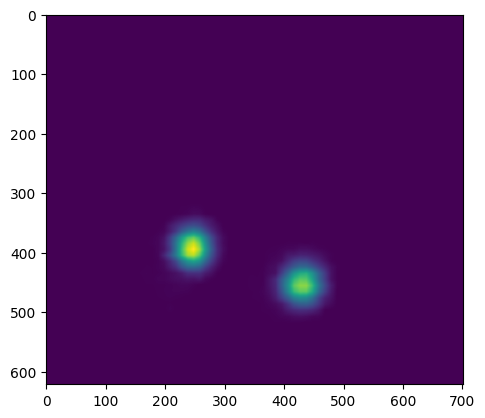

In [34]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## MMPose官方可视化工具`visualizer`

In [35]:
# 半径
pose_estimator.cfg.visualizer.radius = 10
# 线宽
pose_estimator.cfg.visualizer.line_width = 8
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

10/09 20:19:59 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [36]:
# 元数据
pose_estimator.dataset_meta

{'dataset_name': 'coco',
 'num_keypoints': 17,
 'keypoint_id2name': {0: 'nose',
  1: 'left_eye',
  2: 'right_eye',
  3: 'left_ear',
  4: 'right_ear',
  5: 'left_shoulder',
  6: 'right_shoulder',
  7: 'left_elbow',
  8: 'right_elbow',
  9: 'left_wrist',
  10: 'right_wrist',
  11: 'left_hip',
  12: 'right_hip',
  13: 'left_knee',
  14: 'right_knee',
  15: 'left_ankle',
  16: 'right_ankle'},
 'keypoint_name2id': {'nose': 0,
  'left_eye': 1,
  'right_eye': 2,
  'left_ear': 3,
  'right_ear': 4,
  'left_shoulder': 5,
  'right_shoulder': 6,
  'left_elbow': 7,
  'right_elbow': 8,
  'left_wrist': 9,
  'right_wrist': 10,
  'left_hip': 11,
  'right_hip': 12,
  'left_knee': 13,
  'right_knee': 14,
  'left_ankle': 15,
  'right_ankle': 16},
 'upper_body_ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'lower_body_ids': [11, 12, 13, 14, 15, 16],
 'flip_indices': [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15],
 'flip_pairs': [(2, 1),
  (1, 2),
  (4, 3),
  (3, 4),
  (6, 5),
  (5, 6),
  (8, 7),
  

## 展示可视化效果

In [37]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show_kpt_idx=True,
            show=False,
            wait_time=0,
            out_file='outputs/B2.jpg'
)

In [38]:
img_output.shape

(1244, 701, 3)

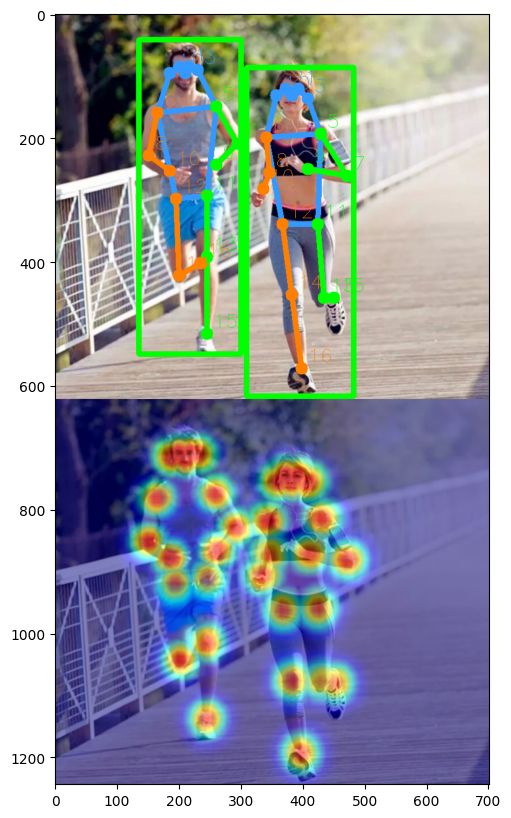

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()